In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
STIM_PROTOCOL = {
    "000": (1, "AS"),
    "001": (2, "AS"),
    "002": (5, "AS"),
    "003": (10, "AS"),
    "004": (0.5, "AS"),
    "005": (0.25, "AS"),
    "006": (0.1, "AS"),
    "007": (1, "1U"),
    "008": (2, "1U"),
    "009": (5, "1U"),
    "010": (7.5, "1U"),
    "011": (10, "1U"),
    "012": (1, "1L"),
    "013": (2, "1L"),
    "014": (5, "1L"),
    "015": (7.5, "1L"),
    "016": (10, "1L"),
    "017": (1, "2U"),
    "018": (2, "2U"),
    # "019": (5, "2U"),
    "020": (5, "2U"),
    "021": (7.5, "2U"),
    "022": (10, "2U"),
    "023": (1, "2L"),
    "024": (2, "2L"),
    # "025": (5, "2L"),
    "026": (5, "2L"),
    "027": (7.5, "2L"),
    "028": (10, "2L"),
    "029": (1, "3U"),
    "030": (2, "3U"),
    "031": (5, "3U"),
    "032": (7.5, "3U"),
    "033": (10, "3U"),
    "034": (1, "3L"),
    "035": (2, "3L"),
    "036": (5, "3L"),
    "037": (7.5, "3L"),
    "038": (10, "3L"),
    "039": (1, "4U"),
    "040": (2, "4U"),
    "041": (5, "4U"),
    "042": (7.5, "4U"),
    "043": (10, "4U"),
    "044": (1, "4L"),
    "045": (2, "4L"),
    "046": (5, "4L"),
    "047": (7.5, "4L"),
    "048": (10, "4L"),
}

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm

from cheese3d.anatomy import compute_measurements_df
from cheese3d.readers import read_3d_data

In [4]:
DATA_PATH = "demo-data"
COORDINATE_PATHS = {}
key_cols = ("run",)
for p in Path(DATA_PATH).glob("*/pose-3d/*.csv"):
    run = p.stem
    if run not in STIM_PROTOCOL.keys():
        continue
    COORDINATE_PATHS[(run,)] = p
data_keys = list(COORDINATE_PATHS.keys())
data_keys

[('048',),
 ('026',),
 ('008',),
 ('010',),
 ('045',),
 ('040',),
 ('043',),
 ('016',),
 ('035',),
 ('042',),
 ('029',),
 ('007',),
 ('022',),
 ('015',),
 ('036',),
 ('044',),
 ('041',),
 ('017',),
 ('046',),
 ('001',),
 ('003',),
 ('006',),
 ('005',),
 ('039',),
 ('020',),
 ('034',),
 ('037',),
 ('028',),
 ('000',),
 ('012',),
 ('013',),
 ('031',),
 ('009',),
 ('023',),
 ('018',),
 ('002',),
 ('021',),
 ('004',),
 ('047',),
 ('030',),
 ('038',),
 ('011',),
 ('032',),
 ('024',),
 ('014',),
 ('033',),
 ('027',)]

In [5]:
coord_data = {k: read_3d_data(v.parent.parent.as_posix())
              for k, v in COORDINATE_PATHS.items()}

meas_df = compute_measurements_df(coord_data, key_columns=key_cols)
meas_df

,run,measurement_group,measurement_name,measurement_units,measurement_type,measurement_value,std,count,timeseries
0,048,eye,eye-height-left,mm,distance,2.462970,0.006810,3038,"[2.459827362289357, 2.459903743727629, 2.45998..."
1,048,eye,eye-height-right,mm,distance,2.586450,0.007293,3038,"[2.5969709591399917, 2.5970417689025607, 2.597..."
2,048,eye,eye-width-left,mm,distance,3.894542,0.008223,3038,"[3.8887721920657037, 3.888676747401042, 3.8886..."
3,048,eye,eye-width-right,mm,distance,3.578795,0.008944,3038,"[3.585963392932364, 3.5859779475486437, 3.5859..."
4,048,eye,eye-area-left,mm^2,area,7.564021,0.022574,3038,"[7.54100897221169, 7.540950607476873, 7.541189..."
...,...,...,...,...,...,...,...,...,...
794,027,ear,ear-area-left,mm^2,area,9072.988116,4.288188,3329,"[9068.058691867494, 9067.890187985155, 9067.86..."
795,027,ear,ear-area-right,mm^2,area,12207.706582,75.621604,3329,"[12280.266469986871, 12280.274929883108, 12280..."
796,027,mouth,mouth-area,mm^2,area,4.654239,0.145111,3329,"[4.549676846845778, 4.550643930738976, 4.55193..."
797,027,nose,nose-bulge-volume,mm^3,volume,9.629620,0.054516,3329,"[9.758480195434014, 9.758146377614594, 9.75728..."


In [6]:
def build_ephys_df(data_keys, run_map):
    df = []
    for key in tqdm(data_keys, desc="reading ephys"):
        run = key[0]
        with open(os.sep.join([DATA_PATH, "ephys-stim", f"{run}.npy"]), "rb") as f:
            stim_times = np.load(f)
        stim_amp, stim_loc = run_map[run]
        if stim_loc == "AS":
            stim_shank = "A"
            stim_depth = "A"
        else:
            stim_shank, stim_depth = stim_loc
        df.append([run,
                   stim_amp, len(stim_times),
                   stim_shank, stim_depth, "right",
                   stim_times])

    df = pd.DataFrame(df, columns=[*key_cols,
                                   "stim_amplitude", "nrepeats",
                                   "stim_shank", "stim_depth", "stim_side",
                                   "stim_times"])

    return df

ephys_df = build_ephys_df(data_keys, STIM_PROTOCOL)
ephys_df

reading ephys:   0%|          | 0/47 [00:00<?, ?it/s]

,run,stim_amplitude,nrepeats,stim_shank,stim_depth,stim_side,stim_times
0,048,10.00,10,4,L,right,"[4.978694431473655, 7.180810237801142, 9.37273..."
1,026,5.00,10,2,L,right,"[4.930127233721467, 7.193240405886116, 9.66342..."
2,008,2.00,10,1,U,right,"[6.295970129067389, 8.817417037908077, 11.4255..."
3,010,7.50,13,1,U,right,"[5.771549697574434, 8.311204596717936, 11.0803..."
4,045,2.00,10,4,L,right,"[5.672105562362554, 7.375501488115193, 9.88059..."
5,040,2.00,10,4,U,right,"[3.907851406485356, 5.992727254274841, 8.20612..."
6,043,10.00,10,4,U,right,"[4.993431883381984, 7.467888191476755, 10.1748..."
7,016,10.00,10,1,L,right,"[4.773029822383111, 7.295411419155315, 10.1267..."
8,035,2.00,10,3,L,right,"[5.532373527998394, 7.7873692233312255, 10.221..."
9,042,7.50,10,4,U,right,"[4.1911879200122435, 6.443322145816752, 8.8341..."


In [7]:
def _select_ephys_row(row):
    ephys_row = ephys_df.query("run == @row.run")

    return ephys_row[["stim_amplitude",
                      "nrepeats",
                      "stim_shank",
                      "stim_depth",
                      "stim_side",
                      "stim_times"]].squeeze()

merge_df = pd.concat([meas_df, meas_df.apply(_select_ephys_row, axis=1)], axis=1)
merge_df

,run,measurement_group,measurement_name,measurement_units,measurement_type,measurement_value,std,count,timeseries,stim_amplitude,nrepeats,stim_shank,stim_depth,stim_side,stim_times
0,048,eye,eye-height-left,mm,distance,2.462970,0.006810,3038,"[2.459827362289357, 2.459903743727629, 2.45998...",10.0,10,4,L,right,"[4.978694431473655, 7.180810237801142, 9.37273..."
1,048,eye,eye-height-right,mm,distance,2.586450,0.007293,3038,"[2.5969709591399917, 2.5970417689025607, 2.597...",10.0,10,4,L,right,"[4.978694431473655, 7.180810237801142, 9.37273..."
2,048,eye,eye-width-left,mm,distance,3.894542,0.008223,3038,"[3.8887721920657037, 3.888676747401042, 3.8886...",10.0,10,4,L,right,"[4.978694431473655, 7.180810237801142, 9.37273..."
3,048,eye,eye-width-right,mm,distance,3.578795,0.008944,3038,"[3.585963392932364, 3.5859779475486437, 3.5859...",10.0,10,4,L,right,"[4.978694431473655, 7.180810237801142, 9.37273..."
4,048,eye,eye-area-left,mm^2,area,7.564021,0.022574,3038,"[7.54100897221169, 7.540950607476873, 7.541189...",10.0,10,4,L,right,"[4.978694431473655, 7.180810237801142, 9.37273..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,027,ear,ear-area-left,mm^2,area,9072.988116,4.288188,3329,"[9068.058691867494, 9067.890187985155, 9067.86...",7.5,10,2,L,right,"[4.437292072714341, 6.933539921175645, 9.54192..."
795,027,ear,ear-area-right,mm^2,area,12207.706582,75.621604,3329,"[12280.266469986871, 12280.274929883108, 12280...",7.5,10,2,L,right,"[4.437292072714341, 6.933539921175645, 9.54192..."
796,027,mouth,mouth-area,mm^2,area,4.654239,0.145111,3329,"[4.549676846845778, 4.550643930738976, 4.55193...",7.5,10,2,L,right,"[4.437292072714341, 6.933539921175645, 9.54192..."
797,027,nose,nose-bulge-volume,mm^3,volume,9.629620,0.054516,3329,"[9.758480195434014, 9.758146377614594, 9.75728...",7.5,10,2,L,right,"[4.437292072714341, 6.933539921175645, 9.54192..."


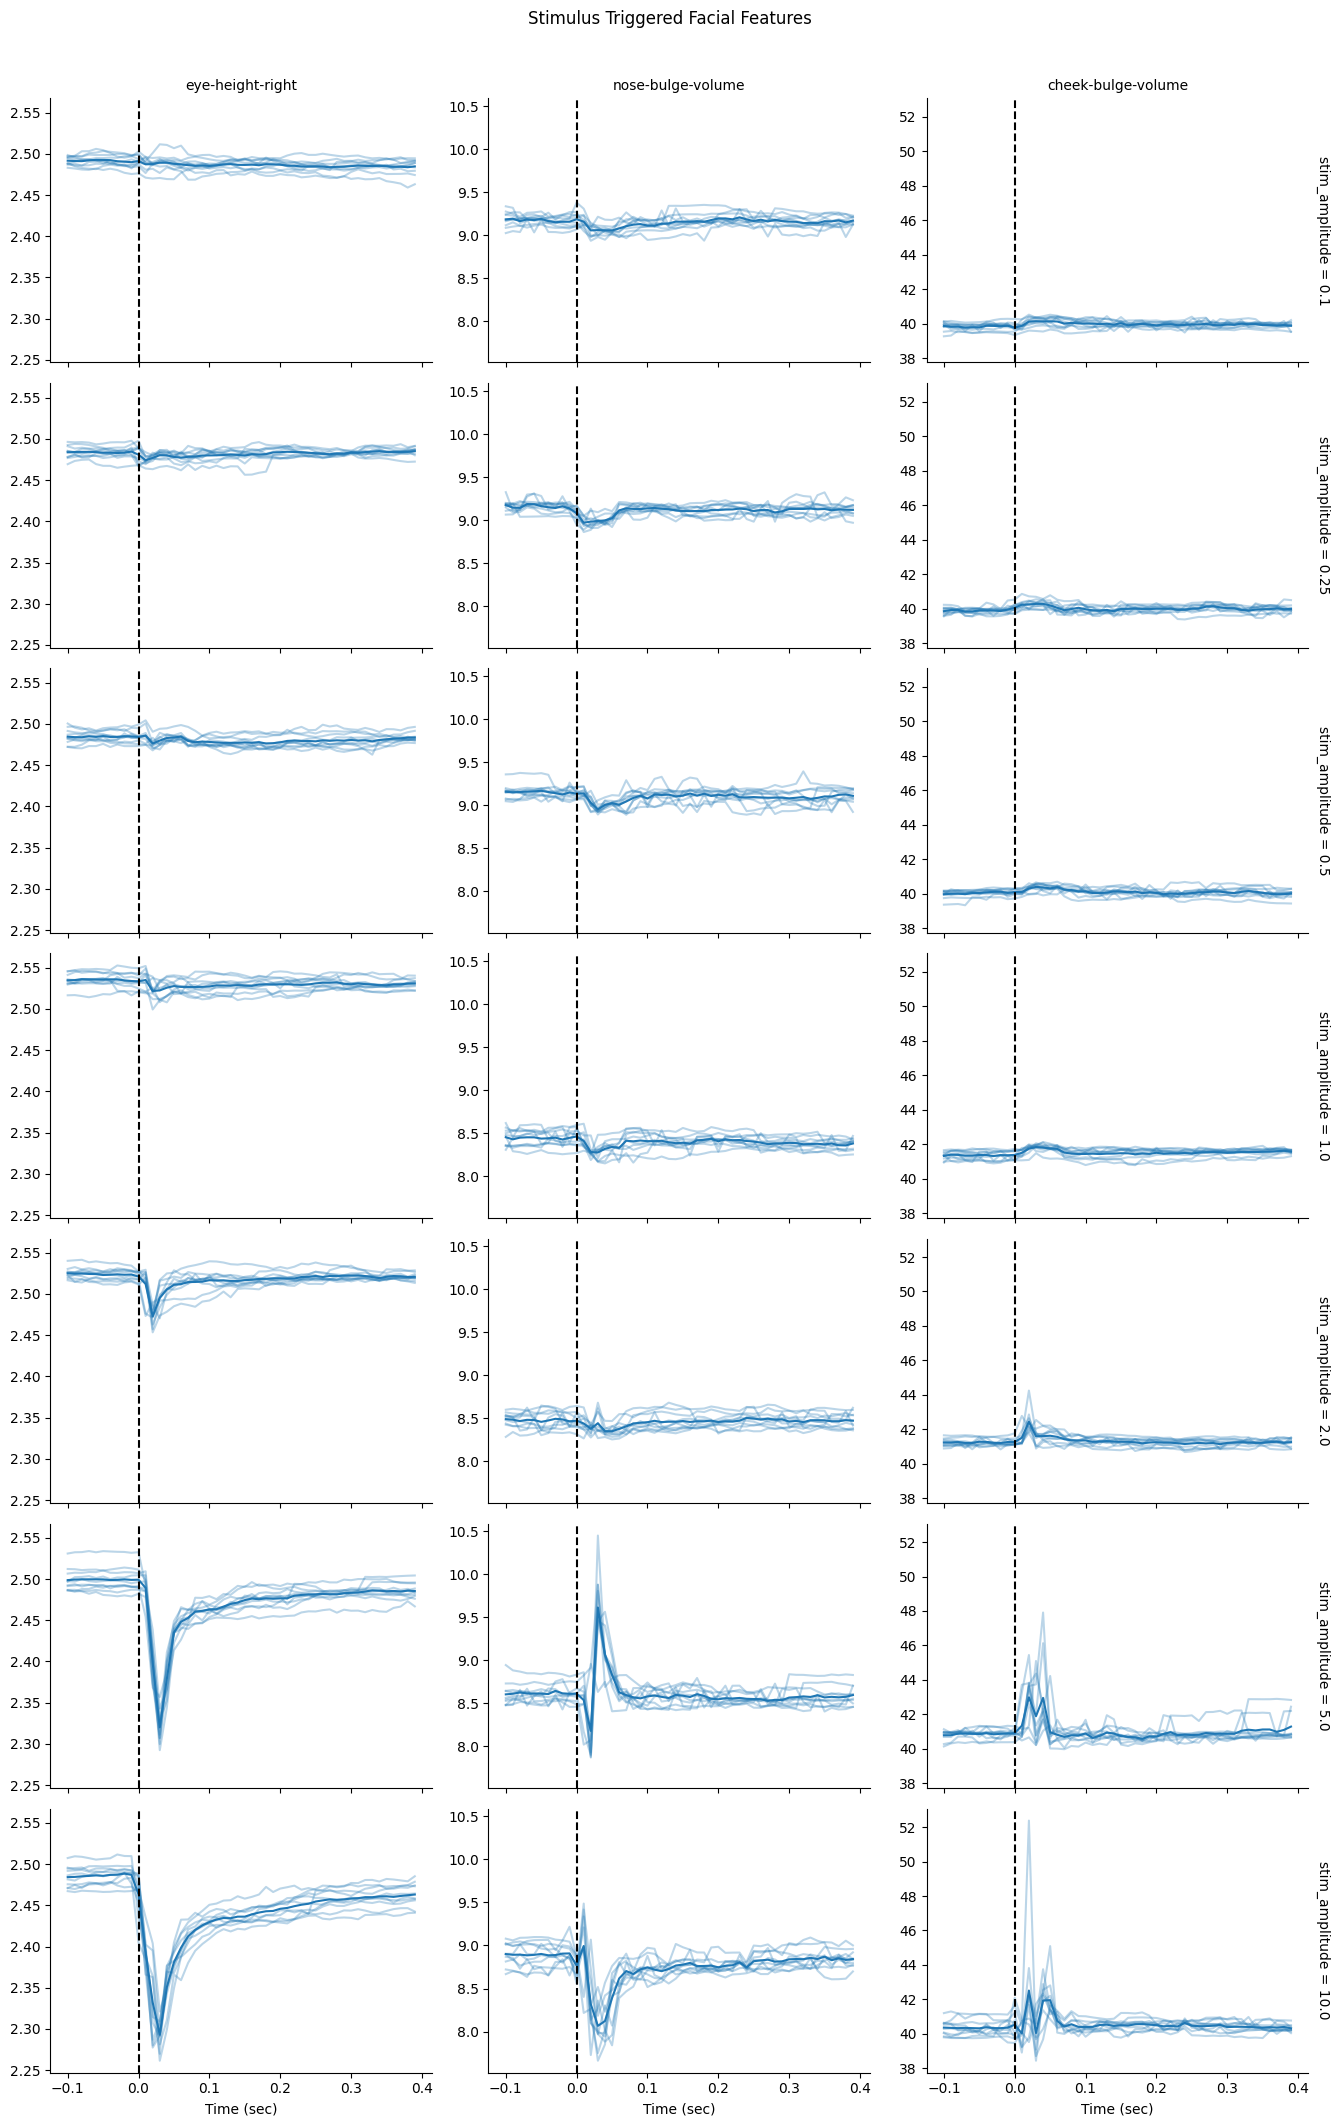

In [10]:
def _time_to_frame(ts):
    return np.floor(ts * 100).astype(int)

def plot_stim_align_helper(stim_times, timeseries, color):
    stim_times = _time_to_frame(stim_times.values[0])
    timeseries = timeseries.values[0]
    t_prestim = int(0.1 * 100) # 0.1 seconds before stim
    t_poststim = int(0.4 * 100) # 0.4 seconds after stim
    ys = [timeseries[(t - t_prestim):(t + t_poststim)] for t in stim_times]
    xs = [(np.arange(len(y)) - t_prestim) / 100 for y in ys]
    for x, y in zip(xs, ys):
        sns.lineplot(x=x, y=y, color=color, alpha=0.3)
    sns.lineplot(x=np.concatenate(xs), y=np.concatenate(ys),
                 color=color, errorbar=None)
    plt.axvline(0, color="black", linestyle="dashed")

measurements = ["eye-height-right",
                "nose-bulge-volume",
                "cheek-bulge-volume"]
g = sns.FacetGrid(merge_df.query("stim_shank == 'A' & stim_depth == 'A' & "
                                 "measurement_name in @measurements"),
                  row="stim_amplitude", col="measurement_name",
                  row_order=merge_df["stim_amplitude"].unique().sort(),
                  col_order=measurements,
                  sharey="col",
                  aspect=1.5,
                  margin_titles=True)
g.map(plot_stim_align_helper, "stim_times", "timeseries")
g.figure.suptitle(f"Stimulus Triggered Facial Features", y=1.01)
g.set_xlabels("Time (sec)")
g.set_ylabels("")
g.set_titles(col_template="{col_name}")
sns.despine(g.figure)
g.tight_layout()